In [1]:
###agent_1

importing Jupyter notebook from snake_env.ipynb
importing Jupyter notebook from plot_script.ipynb
final state before dying: [[1 0 0 1 0 1 0 0 0 1 0 0]]
episode: 1/50, score: -94
final state before dying: [[1 1 0 0 0 0 0 1 0 0 0 1]]
episode: 2/50, score: -102
final state before dying: [[1 1 0 0 0 0 0 1 0 0 1 0]]
episode: 3/50, score: -113
final state before dying: [[1 0 0 1 0 1 0 0 0 1 0 0]]
episode: 4/50, score: -93
final state before dying: [[0 1 1 0 1 0 0 0 1 0 0 0]]
episode: 5/50, score: -103
final state before dying: [[1 1 0 0 0 0 1 0 0 0 1 0]]
episode: 6/50, score: -109
final state before dying: [[0 1 1 0 1 0 0 0 0 1 0 0]]
episode: 7/50, score: -96
final state before dying: [[1 0 0 1 0 1 0 0 0 1 0 0]]
episode: 8/50, score: -101
final state before dying: [[0 1 1 0 1 0 0 0 0 0 0 1]]
episode: 9/50, score: -97
final state before dying: [[0 0 1 1 1 0 0 0 1 0 0 0]]
episode: 10/50, score: -79
final state before dying: [[0 0 1 1 1 1 0 0 0 1 0 0]]
episode: 11/50, score: -118
final state be

<string>:69: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001B5A44C3280> has a label of '_line0' which cannot be automatically added to the legend.


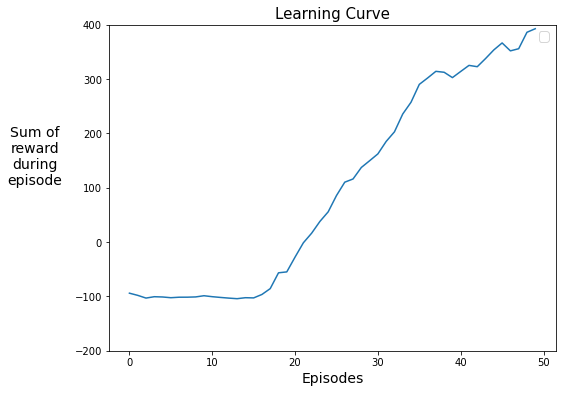

In [1]:
import import_ipynb
from snake_env import Snake
from plot_script import plot_result1

import random
import numpy as np
from keras import Sequential
from collections import deque
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import time


class DQN:

    """ Deep Q Network """

    def __init__(self, env, params):

        self.action_space = env.action_space
        self.state_space = env.state_space
        self.epsilon = params['epsilon'] 
        self.gamma = params['gamma'] 
        self.batch_size = params['batch_size'] 
        self.epsilon_min = params['epsilon_min'] 
        self.epsilon_decay = params['epsilon_decay'] 
        self.learning_rate = params['learning_rate']
        self.layer_sizes = params['layer_sizes']
        self.memory = deque(maxlen=2500)
        self.model = self.build_model()


    def build_model(self):
        model = Sequential()
        for i in range(len(self.layer_sizes)):
            if i == 0:
                model.add(Dense(self.layer_sizes[i], input_shape=(self.state_space,), activation='relu'))
            else:
                model.add(Dense(self.layer_sizes[i], activation='relu'))
        model.add(Dense(self.action_space, activation='softmax'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
 

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_dqn(episode, env):

    sum_of_rewards = []
    agent = DQN(env, params)
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, env.state_space))
        score = 0
        max_steps = 10000
        for i in range(max_steps):
            action = agent.act(state)
            # print(action)
            prev_state = state
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, env.state_space))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if params['batch_size'] > 1:
                agent.replay()
            if done:
                print(f'final state before dying: {str(prev_state)}')
                print(f'episode: {e+1}/{episode}, score: {score}')
                break
        sum_of_rewards.append(score)
    return sum_of_rewards


if __name__ == '__main__':

    params = dict()
    params['name'] = None
    params['epsilon'] = 1
    params['gamma'] = .95
    params['batch_size'] = 500
    params['epsilon_min'] = .01
    params['epsilon_decay'] = 1/100
    params['learning_rate'] = 0.00013629
    params['layer_sizes'] = [128, 128, 128]
    

    results = dict()
    ep = 50

    # for batchsz in [1, 10, 100, 1000]:
    #     print(batchsz)
    #     params['batch_size'] = batchsz
    #     nm = ''
    #     params['name'] = f'Batchsize {batchsz}'
    env_infos = {'States: only walls':{'state_space':'no body knowledge'}, 'States: direction 0 or 1':{'state_space':''}, 'States: coordinates':{'state_space':'coordinates'}, 'States: no direction':{'state_space':'no direction'}}

    # for key in env_infos.keys():
    #     params['name'] = key
    #     env_info = env_infos[key]
    #     print(env_info)
    #     env = Snake(env_info=env_info)
    env = Snake()
    sum_of_rewards = train_dqn(ep, env)
    results[params['name']] = sum_of_rewards
    
    plot_result1(results, direct=True, k=20)
    